In [1]:
import sys
sys.path.append('../')
from PIL import Image
import torch
from torchvision.transforms import ToTensor, RandomCrop
from torchvision.utils import save_image

from model.DocDiff import DocDiff
from schedule.diffusionSample import GaussianDiffusion
from schedule.schedule import Schedule

def min_max(array):
    return (array - array.min()) / (array.max() - array.min())
def crop_concat(img, size=128):
    shape = img.shape
    correct_shape = (size*(shape[2]//size+1), size*(shape[3]//size+1))
    one = torch.ones((shape[0], shape[1], correct_shape[0], correct_shape[1]))
    one[:, :, :shape[2], :shape[3]] = img
    # crop
    for i in range(shape[2]//size+1):
        for j in range(shape[3]//size+1):
            if i == 0 and j == 0:
                crop = one[:, :, i*size:(i+1)*size, j*size:(j+1)*size]
            else:
                crop = torch.cat((crop, one[:, :, i*size:(i+1)*size, j*size:(j+1)*size]), dim=0)
    return crop
def crop_concat_back(img, prediction, size=128):
    shape = img.shape
    for i in range(shape[2]//size+1):
        for j in range(shape[3]//size+1):
            if j == 0:
                crop = prediction[(i*(shape[3]//size+1)+j)*shape[0]:(i*(shape[3]//size+1)+j+1)*shape[0], :, :, :]
            else:
                crop = torch.cat((crop, prediction[(i*(shape[3]//size+1)+j)*shape[0]:(i*(shape[3]//size+1)+j+1)*shape[0], :, :, :]), dim=3)
        if i == 0:
            crop_concat = crop
        else:
            crop_concat = torch.cat((crop_concat, crop), dim=2)
    return crop_concat[:, :, :shape[2], :shape[3]]

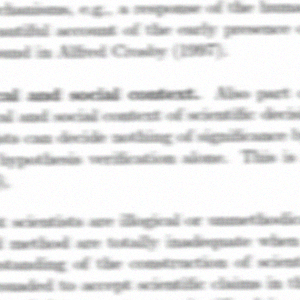

In [2]:
# plot demo image
img = Image.open('./0000184_blur.png')
img = img.convert('RGB')
img

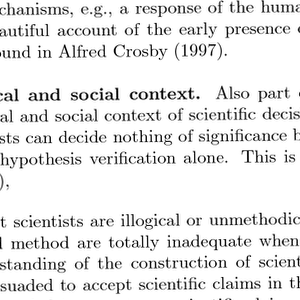

In [3]:
gt = Image.open('./0000184_orig.png')
gt = gt.convert('RGB')
gt

In [4]:
# image pre-processing
seed = torch.random.seed()
torch.random.manual_seed(seed)
# Since the pre-trained weights I provided were padded using the 'reflect' method,
# I need to align the data during testing. Anyway, just remember that aligning the
# training and inference data in the same way is definitely correct.
img = RandomCrop(304, pad_if_needed=True, padding_mode='reflect')(img)
img = ToTensor()(img) # convert to tensor
img = img.unsqueeze(0) # add batch dimension (1, 3, 300, 300)

torch.random.manual_seed(seed)
gt = RandomCrop(304, pad_if_needed=True, padding_mode='reflect')(gt)
gt = ToTensor()(gt) # convert to tensor
gt = gt.unsqueeze(0) # add batch dimension (1, 3, 300, 300)

In [5]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
network = DocDiff(
    input_channels=3 + 3,
    output_channels=3,
    n_channels=32,
    ch_mults=[1,2,3,4],
    n_blocks=1,
).to(device) # initialize network

In [6]:
TEST_INITIAL_PREDICTOR_WEIGHT_PATH = '../checksave/init.pth'
TEST_DENOISER_WEIGHT_PATH = '../checksave/denoiser.pth'
network.init_predictor.load_state_dict(torch.load(TEST_INITIAL_PREDICTOR_WEIGHT_PATH, map_location=device)) # load weights
network.denoiser.load_state_dict(torch.load(TEST_DENOISER_WEIGHT_PATH, map_location=device))

<All keys matched successfully>

In [7]:
network.eval()

DocDiff(
  (denoiser): UNet(
    (image_proj): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb): TimeEmbedding(
      (lin1): Linear(in_features=32, out_features=128, bias=True)
      (act): Swish()
      (lin2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down): ModuleList(
      (0): DownBlock(
        (res): ResidualBlock(
          (act1): Swish()
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act2): Swish()
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (shortcut): Identity()
          (time_emb): Linear(in_features=128, out_features=32, bias=True)
          (time_act): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Downsample(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (2): DownBlock(
        (res): ResidualBlock(
          (act1): Swish()
  

In [10]:
from torch import nn

num_format = "{:,}".format
def count_parameters(model: nn.Module) -> str:
    """Count the number of learnable parameters of a model"""
    return num_format(sum(p.numel() for p in model.parameters() if p.requires_grad))

count_parameters(network)

'8,208,358'

In [11]:
schedule = Schedule('linear', 100) # initialize schedule
sampler = GaussianDiffusion(network.denoiser, 100, schedule).to(device) # initialize diffusion sampler

In [13]:
# full-size sampling
with torch.no_grad():
    noisyImage = torch.randn_like(img).to(device)
    init_predict = network.init_predictor(img.to(device), 0)
    sampledImgs = sampler(noisyImage.to(device), init_predict, 'True') # full-size sampling
    finalImgs = (sampledImgs + init_predict)
    img_save = torch.cat((img, gt, init_predict.cpu(), min_max(sampledImgs.cpu()), finalImgs.cpu()), dim=3)
    save_image(img_save, './res_nonative.png') # Due to deterministic sampling, the results should always be exactly the same each time.

time_step:  99
time_step:  98
time_step:  97
time_step:  96
time_step:  95
time_step:  94
time_step:  93
time_step:  92
time_step:  91
time_step:  90
time_step:  89
time_step:  88
time_step:  87
time_step:  86
time_step:  85
time_step:  84
time_step:  83
time_step:  82
time_step:  81
time_step:  80
time_step:  79
time_step:  78
time_step:  77
time_step:  76
time_step:  75
time_step:  74
time_step:  73
time_step:  72
time_step:  71


time_step:  70
time_step:  69
time_step:  68
time_step:  67
time_step:  66
time_step:  65
time_step:  64
time_step:  63
time_step:  62
time_step:  61
time_step:  60
time_step:  59
time_step:  58
time_step:  57
time_step:  56
time_step:  55
time_step:  54
time_step:  53
time_step:  52
time_step:  51
time_step:  50
time_step:  49
time_step:  48
time_step:  47
time_step:  46
time_step:  45
time_step:  44
time_step:  43
time_step:  42
time_step:  41
time_step:  40
time_step:  39
time_step:  38
time_step:  37
time_step:  36
time_step:  35
time_step:  34
time_step:  33
time_step:  32
time_step:  31
time_step:  30
time_step:  29
time_step:  28
time_step:  27
time_step:  26
time_step:  25
time_step:  24
time_step:  23
time_step:  22
time_step:  21
time_step:  20
time_step:  19
time_step:  18
time_step:  17
time_step:  16
time_step:  15
time_step:  14
time_step:  13
time_step:  12
time_step:  11
time_step:  10
time_step:  9
time_step:  8
time_step:  7
time_step:  6
time_step:  5
time_step:  4
t

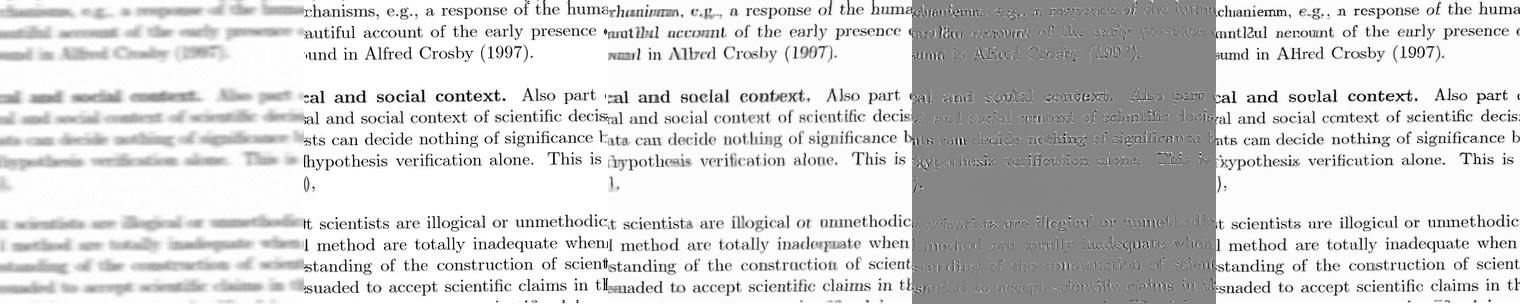

In [14]:
# plot result
res = Image.open('./res_nonative.png')
res # ori, gt, init, sampled, final

In [16]:
# crop-predict-merge sampling
temp = img
img = crop_concat(img) # crop
with torch.no_grad():
    noisyImage = torch.randn_like(img).to(device)
    init_predict = network.init_predictor(img.to(device), 0)
    sampledImgs = sampler(noisyImage.to(device), init_predict, 'True') # 128 * 128 sampling
    finalImgs = (sampledImgs + init_predict)
    finalImgs = crop_concat_back(temp, finalImgs)
    init_predict = crop_concat_back(temp, init_predict)
    sampledImgs = crop_concat_back(temp, sampledImgs)
    img = temp
    img_save = torch.cat((img, gt, init_predict.cpu(), min_max(sampledImgs.cpu()), finalImgs.cpu()), dim=3)
    save_image(img_save, './res_native.png')

time_step:  99
time_step:  98
time_step:  97
time_step:  96
time_step:  95
time_step:  94
time_step:  93
time_step:  92
time_step:  91
time_step:  90
time_step:  89
time_step:  88
time_step:  87
time_step:  86
time_step:  85
time_step:  84
time_step:  83
time_step:  82
time_step:  81
time_step:  80
time_step:  79
time_step:  78
time_step:  77
time_step:  76
time_step:  75
time_step:  74
time_step:  73
time_step:  72
time_step:  71
time_step:  70
time_step:  69
time_step:  68
time_step:  67
time_step:  66
time_step:  65
time_step:  64
time_step:  63
time_step:  62
time_step:  61
time_step:  60
time_step:  59
time_step:  58
time_step:  57
time_step:  56
time_step:  55
time_step:  54
time_step:  53
time_step:  52
time_step:  51
time_step:  50
time_step:  49
time_step:  48
time_step:  47
time_step:  46
time_step:  45
time_step:  44
time_step:  43
time_step:  42
time_step:  41
time_step:  40
time_step:  39
time_step:  38
time_step:  37
time_step:  36
time_step:  35
time_step:  34
time_step:

RuntimeError: Sizes of tensors must match except in dimension 3. Expected size 9 but got size 1 for tensor number 1 in the list.

In [ ]:
# plot result
res = Image.open('./res_native.png')
res # ori, gt, init, sampled, final

In [ ]:
# refine DEGAN results without joint training
DEGANRES = Image.open('./DEGAN_0000184.png')
DEGANRES = DEGANRES.convert('RGB')
DEGANRES

In [ ]:
DEGANRES = RandomCrop(304, pad_if_needed=True, padding_mode='reflect')(DEGANRES)
DEGANRES = ToTensor()(DEGANRES) # convert to tensor
DEGANRES = DEGANRES.unsqueeze(0) # add batch dimension (1, 3, 300, 300)

In [ ]:
# crop-predict-merge refinement
temp = DEGANRES
DEGANRES = crop_concat(DEGANRES) # crop
with torch.no_grad():
    noisyImage = torch.randn_like(DEGANRES).to(device)
    init_predict = DEGANRES.cuda()
    sampledImgs = sampler(noisyImage.cuda(), init_predict, 'True') # full-size sampling
    finalImgs = (sampledImgs + init_predict)
    finalImgs = crop_concat_back(temp, finalImgs)
    init_predict = crop_concat_back(temp, init_predict)
    sampledImgs = crop_concat_back(temp, sampledImgs)
    img_save = torch.cat((img.cpu(), gt.cpu(), init_predict.cpu(), min_max(sampledImgs.cpu()), finalImgs.cpu()), dim=3)
    save_image(img_save, './res_refine.png') # Due to deterministic sampling, the results should always be exactly the same each time.

In [ ]:
# plot result
res = Image.open('./res_refine.png')
res # ori, gt, init, sampled, final

In [ ]:
# refine DEGAN results without joint training
DEGANRES = Image.open('./DEGAN_0001260.png')
DEGANRES = DEGANRES.convert('RGB')
DEGANRES

In [ ]:
DEGANRES = RandomCrop(304, pad_if_needed=True, padding_mode='reflect')(DEGANRES)
DEGANRES = ToTensor()(DEGANRES) # convert to tensor
DEGANRES = DEGANRES.unsqueeze(0) # add batch dimension (1, 3, 300, 300)

In [ ]:
# full-size refinement
with torch.no_grad():
    noisyImage = torch.randn_like(DEGANRES).to(device)
    init_predict = DEGANRES.cuda()
    sampledImgs = sampler(noisyImage.cuda(), init_predict, 'True') # full-size sampling
    finalImgs = (sampledImgs + init_predict)
    img_save = torch.cat((init_predict.cpu(), min_max(sampledImgs.cpu()), finalImgs.cpu()), dim=3)
    save_image(img_save, './res_refine2.png') # Due to deterministic sampling, the results should always be exactly the same each time.

In [ ]:
# plot result
res = Image.open('./res_refine2.png')
res # init, sampled, final